<a href="https://colab.research.google.com/github/junhyeongShin/Meditation/blob/master/Baseline_epoch%20100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사용할 패키지

In [1]:
pip install adabelief-tf==0.2.0

In [2]:
# 스트라이드 32 이미지크기 64 레이어 3층 soft sign으로 돌림림
# 배치사이즈 -> 16 이미지 크기 128 레이어 6층 soft sign으로 해보기
# 민수씨 지금 셋팅
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from adabelief_tf import AdaBeliefOptimizer

# TPU 장치 설정

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.13.16.2:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.13.16.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.13.16.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')
path = "/content/gdrive/MyDrive/data/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# 데이터 가져오기

In [5]:
train_csv = pd.read_csv(path+'train.csv')

In [6]:
train_csv.head()

,month,file_nm
0,1978-11,197811.npy
1,1978-12,197812.npy
2,1979-01,197901.npy
3,1979-02,197902.npy
4,1979-03,197903.npy


전체 데이터중 최근 30년 데이터만 학습에 사용하였습니다.

In [7]:
train_path = sorted(glob(path+'train/*.npy'))
train_path = train_path[-40*12:]

In [8]:
train = []
for p in tqdm(train_path):
    train.append(np.load(p))
train = np.array(train)

100%|██████████| 480/480 [00:01<00:00, 316.93it/s]


In [9]:
train.shape

(480, 448, 304, 5)

# 데이터 시각화

# 월별 데이터로 분리

In [10]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :,:])
train_month = np.array(train_month)

In [11]:
train_month.shape

(12, 40, 448, 304, 5)

# 이미지를 잘랐을 때 사이즈가 같도록 패딩

In [12]:
stride = 32
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2]+(stride-train_month.shape[2]%stride),
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]], np.uint8)
temp[:, :,:train_month.shape[2], :train_month.shape[3], :] = train_month
train_month = temp
del temp

In [13]:
train_month.shape

(12, 40, 480, 320, 5)

# 5년 단위로 데이터 전처리

In [14]:
window_size = 5

In [15]:
x_train = []
y_train = []

for i in range(train_month.shape[1]-window_size):
    x_train.append(train_month[:, i:i+window_size, :,:,:])
    y_train.append(train_month[:, i+window_size:i+window_size+1, :,:,:])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

# x_val = []
# y_val = []

# for i in range(val_month.shape[1]-window_size):
#     x_val.append(val_month[:, i:i+window_size, :,:,:])
#     y_val.append(val_month[:, i+window_size:i+window_size+1, :,:,:])
    
# x_val = np.array(x_val)
# y_val = np.array(y_val)

In [16]:
x_train.shape, y_train.shape 
# , x_val.shape, y_val.shape

((35, 12, 5, 480, 320, 5), (35, 12, 1, 480, 320, 5))

# 시각화

특정 월의 5년간 변화와 그 다음 상태

# 데이터 자르기

이미지가 클 경우 ConvLSTM모델의 메모리가 부족하여 가로세로 32px씩 이동하며 128x128로 이미지를 잘랐습니다.

학습에는 2018년까지, 2018년도를 평가 데이터로 활용하여 학습 결과를 2018년(가장 최근년도)에 과적합시켰습니다.

In [17]:
#stride = 32
feature_size = 32
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []
# for y in range(x_val.shape[0]):
for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                y_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                x_val_.append(x_)
                y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

In [18]:
x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

((63000, 5, 32, 32, 1),
 (63000, 1, 32, 32, 1),
 (1800, 5, 32, 32, 1),
 (1800, 5, 32, 32, 1))

# 데이터 시각화

# 데이터셋

In [19]:
#최후의 수단 float64 써보기
@tf.function
def train_map_func(x, y):
    x = tf.cast(x, tf.float32)/250
    y = tf.cast(y, tf.float32)
    return x, y

In [20]:
BATCH_SIZE = 128

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([128, 5, 32, 32, 1]), TensorShape([128, 1, 32, 32, 1]))

In [23]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([128, 5, 32, 32, 1]), TensorShape([128, 5, 32, 32, 1]))

# 계산 메소드들.
@tf.function
def mae_score(true, pred):
    
    return tf.math.reduce_mean(tf.math.abs(true-pred))


@tf.function
def f1_score(true, pred):
    #0.5 이상이면 0 으로 없애버리기
    true = tf.where(true > 125, 0., true) 
    pred = tf.where(pred > 125, 0., pred)

    #0.05 이하면 0 으로 없애버리기
    true = tf.where(true < 12.5, 0., true)
    pred = tf.where(pred < 12.5, 0., pred)

    # 0.15 이상이면 해빙이 있다. 이하면 없다로 판단.
    true = tf.where(true < 37.5, 0., 1.)
    pred = tf.where(pred < 37.5, 0., 1.)

    # tp 는 예측 사진에 해빙이 있고, 실제 사진에도 해빙이 있는 값을 더한 값을 담는 변수다.
    tp = tf.math.reduce_sum(tf.where(true * pred == 1., 1., 0.)) 
    precision = tp / tf.math.reduce_sum(true + 1e-8) 
    recall = tp / tf.math.reduce_sum(pred + 1e-8) 
    score = 2 * precision * recall / (precision + recall + 1e-8)
    
    return score

# mae_over_f1 는 제출할때 사용하는 최종 점수다. 에폭때 loss에 찍히는 값이다.
@tf.function
def mae_over_f1(true, pred):
    # 홈페이지 산식에 없는 mae에 1e-8 을 더한 이유는 학습 초기에 mae 값이 너무 커서 score 계산할때 오류 나는 경우가 있는데 그러면 Nan 값이 넘어오면서 오류가 생긴다. 그거 고치려고 넣었다. 이유는 모르겠지만 더하면 오류 안남.
    return tf.math.divide(mae_score(true, pred), f1_score(true, pred) + 1e-8)
    
nowChackPointNumber = 0
def get_callbacks():
    if not (os.path.isdir('models')):
        os.makedirs('models')

    ## Checkpoint callback.
    # ckpt_path = f"ckpt/ckeckPoint{nowChackPointNumber}/" + "cp-{epoch:03d}-{val_loss:.4f}.ckpt"
    # os.makedirs(os.path.dirname(ckpt_path), exist_ok = True)
    
    callbacks_list = tf.keras.callbacks.ModelCheckpoint(
        filepath = './models/convlstm_model.h5',
        monitor='val_loss',
        save_best_only=True
        
        )

    ## TensorBoard callback.
    # log_dir = f"{path}logs/fit/ckeckPoint{nowChackPointNumber}"
    # tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)
    
    return [callbacks_list]

# 모델

keras를 이용해 간단한 ConvLSTM 모델을 만들었습니다.

메모리가 많이 필요하여 colab TPU 사용을 권장드립니다.

In [24]:
with strategy.scope():
    inputs=Input((None, x_train_.shape[2], x_train_.shape[3], 1))

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', activation = "softsign", return_sequences=True,dropout=0.2)(inputs)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same',activation = "softsign", return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same',activation = "softsign", return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', activation = "softsign", return_sequences=True)(inputs)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same',activation = "softsign", return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same',activation = "softsign", return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    outputs = Conv3D(filters=1, kernel_size=3, activation='relu', padding='same', data_format='channels_last')(convLSTM)

    model = Model(inputs, outputs)
    # model.compile(loss= "mae", optimizer = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False))
    model.compile(loss= "mae", optimizer = Adam())

    #로스 변경해보기
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 32, 32, 1)] 0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 32, 32, 64)  150016    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 32, 32, 64)  256       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, 32, 32, 64)  295168    
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 32, 32, 64)  256       
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, None, 32, 32, 64)  295168    
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 32, 32, 64)  256   

# 학습

20epochs까지만 학습하였습니다.

In [25]:
if not (os.path.isdir('models')):
    os.makedirs('models')

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = './models/convlstm_model.h5',
        monitor='val_loss',  
        save_best_only=True
    )
]

hist = model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=callbacks_list)

Epoch 1/100
493/493 [==============================] - 93s 156ms/step - loss: 12.9406 - val_loss: 17.2684
Epoch 2/100
493/493 [==============================] - 60s 122ms/step - loss: 5.7441 - val_loss: 3.1226
Epoch 3/100
493/493 [==============================] - 60s 122ms/step - loss: 4.6511 - val_loss: 2.8674
Epoch 4/100
493/493 [==============================] - 60s 122ms/step - loss: 4.2904 - val_loss: 2.7487
Epoch 5/100
493/493 [==============================] - 60s 122ms/step - loss: 4.1494 - val_loss: 2.5053
Epoch 6/100
493/493 [==============================] - 60s 122ms/step - loss: 4.0435 - val_loss: 2.6534
Epoch 7/100
493/493 [==============================] - 60s 122ms/step - loss: 3.9947 - val_loss: 2.6662
Epoch 8/100
493/493 [==============================] - 60s 122ms/step - loss: 3.9522 - val_loss: 2.6630
Epoch 9/100
493/493 [==============================] - 60s 122ms/step - loss: 3.9313 - val_loss: 2.5270
Epoch 10/100
493/493 [==============================] - 60s 12



# 학습 결과

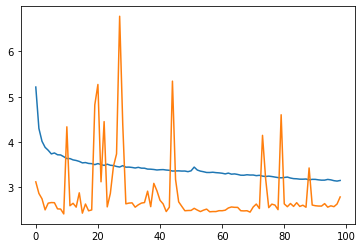

In [26]:
plt.plot(hist.history['loss'][1:])
plt.plot(hist.history['val_loss'][1:])
plt.show()

# 모델 불러오기

In [49]:
model = load_model('./models/convlstm_model.h5')
# model = load_model('./models/convlstm_model.h5', custom_objects={'AdaBeliefOptimizer': AdaBeliefOptimizer}) 
#, custom_objects = {
#     "f1_score" : f1_score,
# }

# 검증셋 추론

In [50]:
#2018 년 추론 결과를 대회에서 제공해주는 산식으로 확인.
train_month = []
for i in range(12):
    train_month.append(train[i::12, :,:])
train_month = np.array(train_month)

stride = 32
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2]+(stride-train_month.shape[2]%stride),
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]], np.uint8)
temp[:, :,:train_month.shape[2], :train_month.shape[3], :] = train_month
train_month = temp
del temp

x_test = train_month[:,-1*window_size -1:-1,:,:,:1]
x_test = np.swapaxes(x_test , 0, 1)

x_test_ = []
for m in range(12):
    feature = []
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)

print(x_test_.shape)

preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    preds.append(pred)
preds = np.array(preds)
print(preds.shape)
print(preds.min().min())
print(preds.max().max())

results = []
for m in range(12):
    pred = np.zeros((x_train.shape[-3], x_train.shape[-2]))
    k = 0
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    results.append(pred[:448, :304])
results = np.array(results)
print(results.shape, results.min().min(), results.max().max())


  0%|          | 0/12 [00:00<?, ?it/s]

(12, 150, 5, 32, 32, 1)


100%|██████████| 12/12 [00:12<00:00,  1.03s/it]

(12, 150, 5, 32, 32, 1)
0.0
285.40088
(12, 448, 304) 0.0 272.1314392089844


## 검증셋 추론 결과

(12, 40, 480, 320, 5) (12, 448, 304)


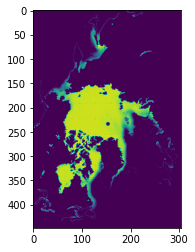

1 



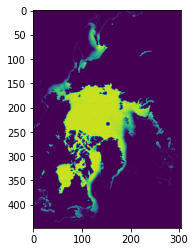

2 



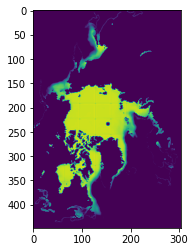

3 



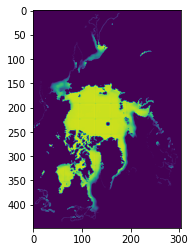

4 



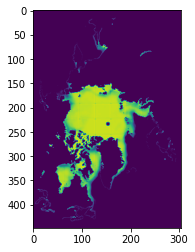

5 



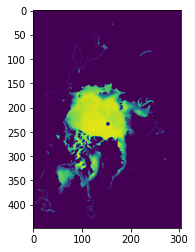

6 



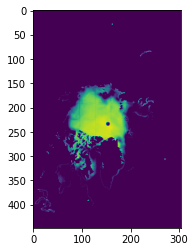

7 



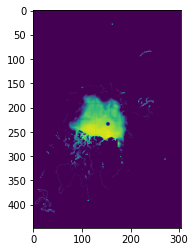

8 



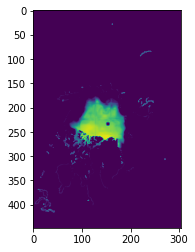

9 



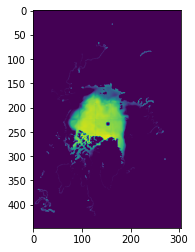

10 



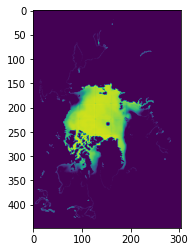

11 



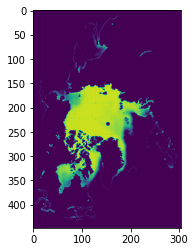

12 

4.4555244624063235


In [51]:

import numpy as np

def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    
    return score

def f1_score(true, pred):
    target = np.where((true>250*0.05)&(true<250*0.5))
    
    true = true[target]
    pred = pred[target]
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score
    
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1+1e-8)
    
    return score

print( train_month.shape, results.shape)
publicScore = []
train2018 = np.array(train_month[:,-1,:448,:304,0], dtype=np.float32)
for m in range(12):
    
    publicScore.append( mae_over_f1(train2018[m] ,results[m] ))
    plt.imshow(results[m])
    plt.show()
    print(m+1, '\n')

publicScore = np.array(publicScore)
print(np.mean(publicScore))

In [ ]:

import numpy as np

def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    
    return score

def f1_score(true, pred):
    target = np.where((true>250*0.05)&(true<250*0.5))
    
    true = true[target]
    pred = pred[target]
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score
    
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1+1e-8)
    
    return score

print( train_month.shape, results.shape)
publicScore = []
train2018 = np.array(train_month[:,-1,:448,:304,0], dtype=np.float32)
for m in range(12):
    
    publicScore.append( mae_over_f1(train2018[m] ,results[m] ))
    plt.imshow(results[m])
    plt.show()
    print(m+1, '\n')

publicScore = np.array(publicScore)
print(np.mean(publicScore))

# 2019년 추론 데이터 전처리

2014 ~ 2018년까지 5년간 월별 데이터를 학습과 같은 형태로 전처리

In [ ]:
x_test = train_month[:,-1*window_size:,:,:,:1]
x_test = np.swapaxes(x_test , 0, 1)

In [ ]:
x_test_ = []
for m in range(12):
    feature = []
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)

In [43]:
x_test_.shape

(12, 150, 5, 32, 32, 1)

# 추론

각 월별 추론하여 저장

In [ ]:
preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)
preds = np.array(preds)
print(preds.shape)

# TTS

추론 결과 중복된 영역의 경우 평균을 이용해 앙상블

stride값이 작을 수록 앙상블에의해 결과가 좋아지나 일정값 이상으로 작아지면 큰 효과가 없고 추론시간이 기하급수적으로 늘어납니다.

In [44]:
voting_mask = np.zeros((x_train.shape[-3], x_train.shape[-2]))
ones = np.ones((feature_size, feature_size))

for i in range((x_train.shape[3]-feature_size)//stride+1):
    for j in range((x_train.shape[4]-feature_size)//stride+1):
        voting_mask[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += ones

평균 계산용 마스크

In [ ]:
plt.imshow(voting_mask)

In [45]:
results = []
for m in range(12):
    pred = np.zeros((x_train.shape[-3], x_train.shape[-2]))
    k = 0
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results.append(pred[:448, :304])
results = np.array(results)
results.shape, results.min(), results.max()

((12, 448, 304), 0.0, 250.0)

# 추론 결과

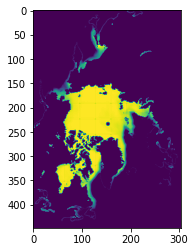

1 



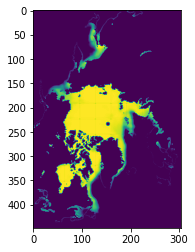

2 



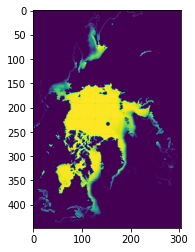

3 



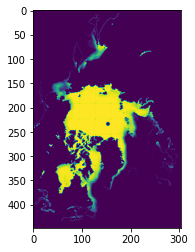

4 



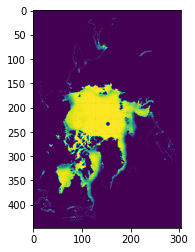

5 



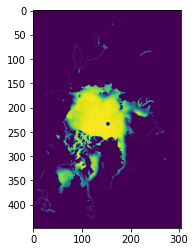

6 



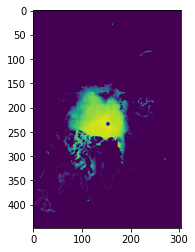

7 



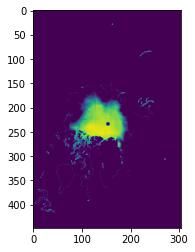

8 



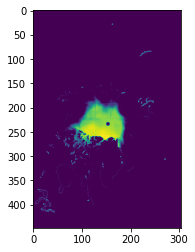

9 



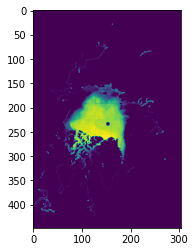

10 



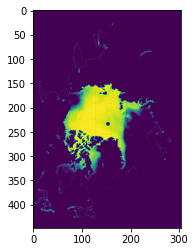

11 



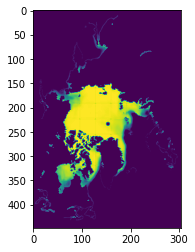

12 



In [46]:
for m in range(12):
    plt.imshow(results[m])
    plt.show()
    print(m+1, '\n')

# 제출

In [ ]:
submission = pd.read_csv(path+'sample_submission.csv')
submission

submission의 값을 변경할 경우 시간이 오래걸려 추론 결과를 reshape하여 붙였습니다.

In [ ]:
sub_2019 = submission.loc[:11, ['month']].copy()
sub_2020 = submission.loc[12:].copy()

sub_2019 = pd.concat([sub_2019, (pd.DataFrame(results.reshape([12,-1])))], axis=1)
sub_2019.columns = submission.columns
submission = pd.concat([sub_2019, sub_2020])

In [47]:
submission

,month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,2019-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2019-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2019-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2019-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2019-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2019-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


결과 저장

In [ ]:
file_name = 'base_code,soft_sign.csv,epoch = 100,drop_out=0.2.csv'

submission.to_csv(file_name, index=False)

In [ ]:
file_path = '/content/'+file_name
try:
    from google.colab import files
    files.download(file_path)
except:
    pass